# Twitter Sentiment Analysis with Twitter API

In [1]:
# import basic library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tweepy

## Connect to Twitter

In [2]:
# API KEY
login = pd.read_csv('secret/twitter.txt')

# login and authetication
api_key = login['key'][0]
api_secret = login['key'][1]
access_token = login['key'][2]
access_token_secret = login['key'][3]

In [3]:
# Authenticate to Twitter
auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

# check authentication
try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


## Data Scrapping

In [4]:
tweets_test = api.home_timeline(count=100, lang='en')

for tweet in tweets_test[0:5]:
    print(tweet.text)
    print('==========')

Neo: The World Ends With You announced for PS4 and Switch
https://t.co/HzW6w4I8ZD https://t.co/zEY2IXYAdP
"It’s just unbelievable. I’m happy to be part of this team, part of this history" ✊

@_fabinhotavares details how h… https://t.co/gDHSii0eVE
⏱️ 19' 

Bir kez daha gole çok yaklaştık! Emre Kılınç'ın serbest vuruştan enfes ortasında Diagne'nin kafa vuruşunu… https://t.co/IFOATl4aKi
Peringatan dini cuaca wilayah Sumatera Selatan [23 November 2020] #BMKG
Selengkapnya klik tautan berikut https://t.co/FcjD7GyoL0
https://t.co/gHBDpLDUlS


In [5]:
query = 'election'
max_tweets = 1000
searched_tweets = [status for status in tweepy.Cursor(api.search, q=query, tweet_mode='extended').items(max_tweets)]

In [6]:
for tweet in searched_tweets[0:5]:
    print(tweet.full_text)
    print('==========')

RT @labourwhips: Key marginal constituencies were targeted during last year’s general election with Facebook adverts - using public money -…
RT @marceelias: 📅Day 20
⏰44 Post-Election Cases.
🇺🇸 6 Total States.
⚖️19 Active Cases.
🏅34 Victories.
https://t.co/XBkKKEmG2Q
I will celebrate big time if this guy goes down...!!!!! #SorosTheSnake
https://t.co/5O1BnI94c4
RT @realDonaldTrump: The Media is just as corrupt as the Election itself!
RT @CNNPolitics: A group of former Republican national security officials are calling on Republican leaders, particularly those in Congress…


In [7]:
# dataframe tweets
tweets_df = pd.DataFrame([tweet.full_text for tweet in searched_tweets], columns=['Tweets'])

tweets_df.head()

,Tweets
0,RT @labourwhips: Key marginal constituencies w...
1,RT @marceelias: 📅Day 20\n⏰44 Post-Election Cas...
2,I will celebrate big time if this guy goes dow...
3,RT @realDonaldTrump: The Media is just as corr...
4,RT @CNNPolitics: A group of former Republican ...


In [8]:
tweets_df.shape

(1000, 1)

In [9]:
# save tweets (unprocessed)
tweets_df.to_csv('data/tweets.txt')

## Preprocessing data

In [10]:
import spacy

# Create spacy 'english' model
nlp = spacy.load('en_core_web_sm')

# create stopwords list with spacy
stopwords = spacy.lang.en.stop_words.STOP_WORDS

# preprocess function with spacy to cleaned data
def preprocess(text):
    doc = nlp(text)
    # lemmas
    lemmas = [token.lemma_ for token in doc]
    lemmas_cleaned = [lemma for lemma in lemmas if lemma.isalpha() \
        and lemma not in [stopwords, 'RT']]
    return ' '.join(lemmas_cleaned)

In [11]:
tweets_df['tweet_cleaned'] = tweets_df['Tweets'].apply(preprocess)

In [12]:
tweets_df[['Tweets', 'tweet_cleaned']]

,Tweets,tweet_cleaned
0,RT @labourwhips: Key marginal constituencies w...,key marginal constituency be target during las...
1,RT @marceelias: 📅Day 20\n⏰44 Post-Election Cas...,Day Post Election Cases Total States Active Ca...
2,I will celebrate big time if this guy goes dow...,will celebrate big time if this guy go down so...
3,RT @realDonaldTrump: The Media is just as corr...,the medium be just as corrupt as the Election
4,RT @CNNPolitics: A group of former Republican ...,a group of former republican national security...
...,...,...
995,“We will not let them steal the vote and take ...,will not let steal the vote and take freedom w...
996,"RT @KassandraSeven: For the record, @billhuize...",for the record statement regard Detroit be utt...
997,"RT @NeeNeinNyetNo: The location, company, and ...",the location company and timing of this electi...
998,RT @bulldoghill: A group of Pennsylvania Repub...,a group of Pennsylvania Republicans have file ...


## TextBlob and WordCloud

In [13]:
from textblob import TextBlob
from wordcloud import WordCloud

In [14]:
# get subjectivity
def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# get polarity
def polarity(text):
    return TextBlob(text).sentiment.polarity

# create two new features
tweets_df['subjectivity'] = tweets_df['tweet_cleaned'].apply(subjectivity)
tweets_df['polarity'] = tweets_df['tweet_cleaned'].apply(polarity)

tweets_df.head()

,Tweets,tweet_cleaned,subjectivity,polarity
0,RT @labourwhips: Key marginal constituencies w...,key marginal constituency be target during las...,0.408333,0.012500
1,RT @marceelias: 📅Day 20\n⏰44 Post-Election Cas...,Day Post Election Cases Total States Active Ca...,0.675000,-0.066667
2,I will celebrate big time if this guy goes dow...,will celebrate big time if this guy go down so...,0.194444,-0.077778
3,RT @realDonaldTrump: The Media is just as corr...,the medium be just as corrupt as the Election,1.000000,-0.500000
4,RT @CNNPolitics: A group of former Republican ...,a group of former republican national security...,0.166667,0.083333


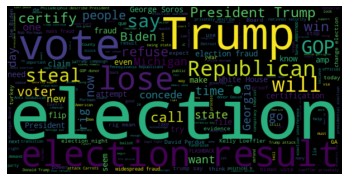

In [15]:
# Visualize data with WordCloud

# create all_words string that is contains all of word in all of tweets
all_words = ' '.join([word for word in tweets_df['tweet_cleaned']])

# initialize wordcloud object
wc = WordCloud(width=600, height=300, random_state=21, max_font_size=144).generate(all_words)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [16]:
# get sentiment either positive, or negative
def get_sentiment(score):
    if score < 0:
        return 'Negative'
    else:
        return 'Positvie'

In [18]:
tweets_df['sentiment'] = tweets_df['polarity'].apply(get_sentiment)

tweets_df['sentiment'].value_counts()

Positvie    782
Negative    218
Name: sentiment, dtype: int64

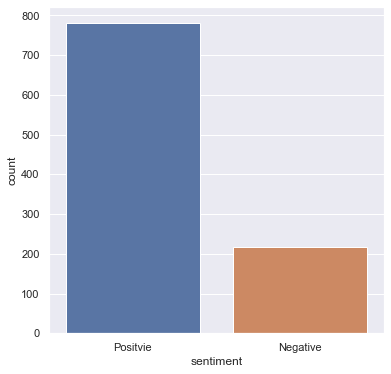

In [19]:
sns.set()
plt.figure(figsize=(6,6))
sns.countplot(tweets_df['sentiment'])

In [52]:
# 10 most positive tweets

tweets_df[['tweet_cleaned', 'polarity']].sort_values(by=['polarity'], ascending=False).head(10)

,tweet_cleaned,polarity
89,THREATS in an election that be PERFECT the ele...,1.0
274,day ago Biden win the election today give repu...,0.8
757,datum Anti Globalism Pro police message win ov...,0.8
873,President elect Joe Biden be expect to name Li...,0.8
449,proud to join this group of national security ...,0.8
643,after clinch Pennsylvania Joe Biden win the Pr...,0.8
300,datum Anti Globalism Pro police message win ov...,0.8
870,protest in Gilgit Baltistan Pak occupy Kashmir...,0.8
756,be request a recount Cob win this election and...,0.8
768,President elect Joe Biden be expect to name Li...,0.8


In [55]:
# 10 most negative tweets

tweets_df[['tweet_cleaned', 'polarity']].sort_values(by=['polarity']).head(10)

,tweet_cleaned,polarity
823,outrageous Congress leave town for holiday thi...,-1.0
543,outrageous Congress leave town for holiday thi...,-1.0
888,outrageous Congress leave town for holiday thi...,-1.0
393,this be truly painful to watch the trump campa...,-0.7
110,how bad do something have to be in order to re...,-0.7
201,the Kraken and Bigfoot still miss the bad guy ...,-0.7
788,over the weekend be ask to read Bad Kitty for ...,-0.7
650,please do not call a Tory enabler a so call so...,-0.7
126,honor the voice of Pennsylvania voter this law...,-0.6
953,honor the voice of Pennsylvania voter this law...,-0.6


In [57]:
# save tweets (processed)
tweets_df.drop(columns=['Tweets']).to_csv('data/tweets_processed.txt')